# AdaBoost (Adaptive Boosting)

## Overview:

AdaBoost is an ensemble technique that combines multiple weak classifiers into a strong classifier. The "weak" classifiers are typically simple and have only a slightly better accuracy than random guessing. AdaBoost is primarily used for classification tasks.

### How It Works:

- Initialization: Each instance in the training dataset is initially given an equal weight.

- Iterative Training: A weak classifier is trained on the data. After each classifier is trained:

    - Weight Update: The weights of misclassified instances are increased, making the classifier focus more on difficult cases in the next iteration.

    - Classifier Weighting: Each classifier is assigned a weight based on its accuracy, with more accurate classifiers having a greater influence on the final decision.

- Combining Classifiers: The final model is a weighted sum of the weak classifiers, where the weights depend on the classifiers' respective accuracies.

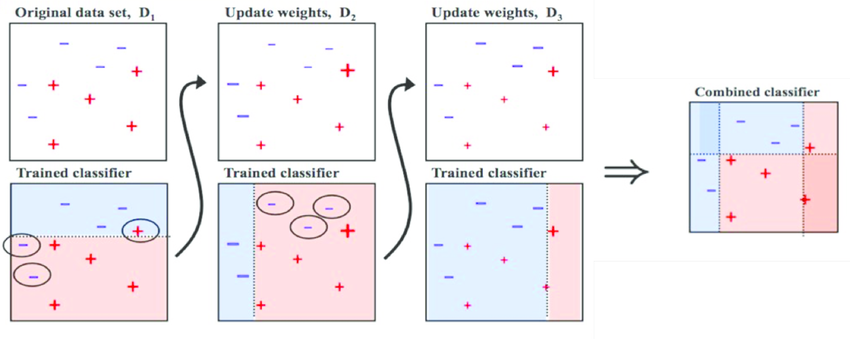

### Advantages:

- Effective in improving the classification accuracy of weak models.

- Simple to implement and fast to train.

- Less prone to overfitting when the underlying weak classifiers are not too complex.

### Disadvantages:

- Sensitive to noisy data and outliers.

- Performance can degrade if the weak classifiers are too complex, leading to overfitting.

# Gradient Boosting

## Overview:

Gradient Boosting is a flexible and powerful machine learning technique used for both regression and classification tasks. It builds an ensemble of predictive models in a stage-wise fashion, with each new model correcting errors made by the previous ones.

### How It Works:

1. Initialization: The model starts with a single weak learner, typically a decision tree.

2. Iterative Improvement:
- Residuals Calculation: For each instance in the training set, calculate the residual, which is the difference between the predicted and actual values.
- New Model: Train a new model on these residuals as labels.
- Model Update: The predictions from this new model are added to the predictions of the existing ensemble.

3. Model Optimization: The learning rate is a key parameter that scales the contribution of each new model. Lower values generally require more models but can lead to better generalization.

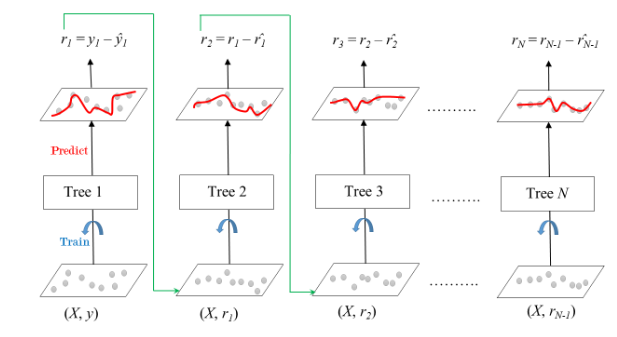

### Advantages:

- Highly effective across a wide range of predictive modeling tasks.

- Can handle different types of data, including heterogeneous features.

- Supports various loss functions, making it adaptable to different scenarios.

### Disadvantages:

- Can be computationally expensive, especially with large data sets and many models.

- More parameters to tune compared to other models, which can make it complex to optimize.

- Prone to overfitting if not tuned properly, especially in the presence of noise.

## Application

We will be implementing AdaBoost and Gradient Boost on two datasets: Breast Cancer Diagnostic and census income. We'll start with the Breast Cancer Diagnostic.

In [24]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X = X.values
y = y.values
y = np.where(y == 'B', 0, 1)
y = y.ravel()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_estimator = DecisionTreeClassifier(max_depth=1) 
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


For AdaBoost, we arbitrarily chose 50 estimators and a learning rate of 1 (default learning rate). This performed exceptionally well, with an accuracy of 98%. Also, since the model is using DT's of max_depth = 1, we are less worried about overfitting. Below we will plot different learning rates and number of estimators, and how it affects the model.

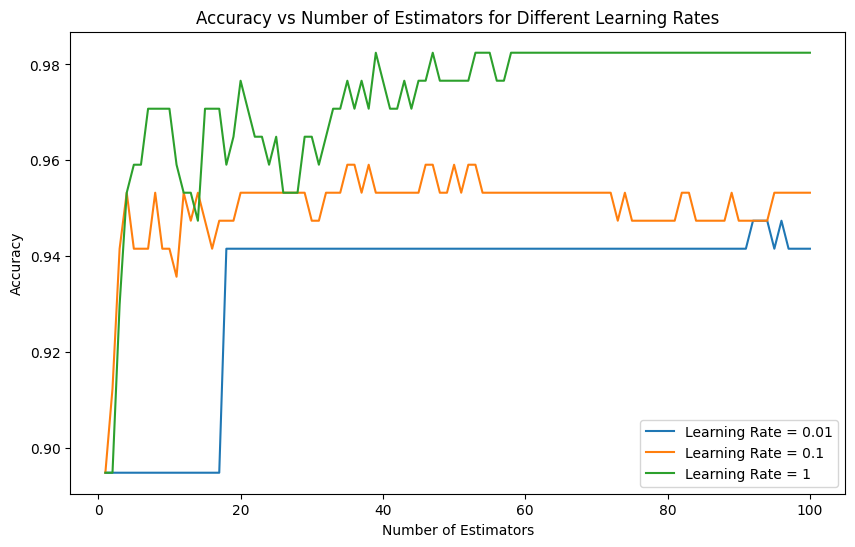

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_estimators = 100
learning_rates = [0.01, 0.1, 1]

fig, ax = plt.subplots(figsize=(10, 6))

for lr in learning_rates:
    acc = []
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n_estimators,
        learning_rate=lr,
        random_state=42
    )

    for i in range(1, n_estimators + 1):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))

    ax.plot(range(1, n_estimators + 1), acc, label=f'Learning Rate = {lr}')

ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Number of Estimators for Different Learning Rates')
ax.legend(loc='lower right')

plt.show()


As we can see, the learning rate = 1 is far and away the best metric. Also, once you pass 50 estimators, the accuracy begins to stabilize. We can infer since this dataset is not too complex, AdaBoost does not require too many estimators to accurately model this dataset. Let's compare with Gradient Boost.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.96


Gradient Boost also fits the dataset very well with an accuracy of 96%. We will now perform Cross Validation to test the best combination of parameters, and if the model is generalizable.

In [25]:
model = GradientBoostingClassifier(random_state=42)

# Define parameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(test_accuracy))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.96
Test set accuracy: 0.95


Here we see the best parameters are {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, with a CV score of 0.96, proving very generalizable and resistant to overfitting. Along with this, we got a test set accuracy of 95%. Let's evaluate this model with a Confusion Matrix, Classification Report, and the ROC curve.


Confusion Matrix:
[[105   3]
 [  4  59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



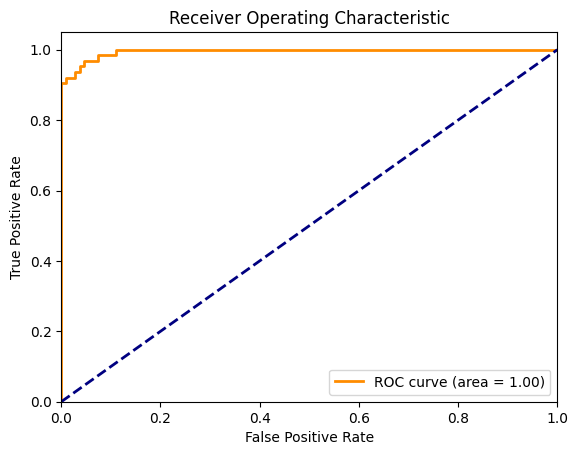

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC Curve
y_probs = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

This model passed all evaluations, and proves itself to be a great fit for the dataset. Both models were a success, so let's try again on a harder dataset, the Census Income.

In [26]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import pandas as pd


census_income = fetch_ucirepo(id=20)

X = census_income.data.features
y = census_income.data.targets

missing_rows = X.isna().any(axis=1)

columns_to_check = ['workclass', 'occupation', 'native-country']
na_indices = X[columns_to_check].isna().any(axis=1)

X = X.drop(na_indices[na_indices].index)
y = y.drop(na_indices[na_indices].index)

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

le = LabelEncoder()

for column in categorical_columns:
    X.loc[:, column] = le.fit_transform(X.loc[:, column])

X = X.values
y = y.values
y = np.where(y == '<=50K', 0, 1)
y = y.ravel()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize AdaBoost with a base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)  # Typically a shallow tree
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.66


While 66% accuracy may not look great on paper, if we think back to the Ensemble Methods this is considerably better. Hard Voting got an accuracy of 59% on this dataset. AdaBoost is proving that while it might not be the best fit, even using shallow trees can begin to find patterns within hard datasets. Let's test which combination of learning rates and number of estimators are best.

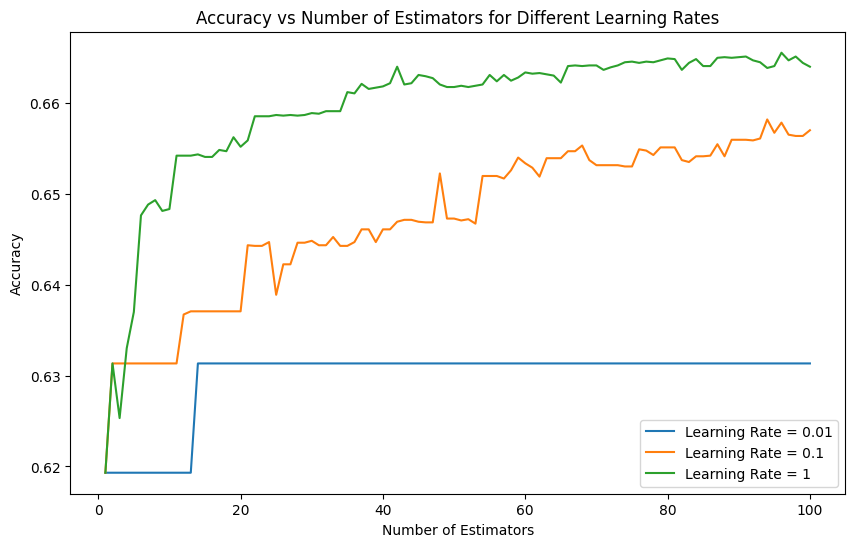

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_estimators = 100
learning_rates = [0.01, 0.1, 1]

fig, ax = plt.subplots(figsize=(10, 6))

for lr in learning_rates:
    acc = []
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n_estimators,
        learning_rate=lr,
        random_state=42
    )

    for i in range(1, n_estimators + 1):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))

    ax.plot(range(1, n_estimators + 1), acc, label=f'Learning Rate = {lr}')

ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Number of Estimators for Different Learning Rates')
ax.legend(loc='lower right')

plt.show()

Once again a learning rate of 1 is superior, with the accuracy once again roughly stabilizing around the 50 estimator mark. Onto the Gradient Boost model.

In [28]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


This time, Gradient Boost proved better than Ada, with a small 2% increase in accuracy. Since this model is extremely large, Cross Validation is too computationally expensive to perform. So let's move onto evaluating this Gradient model.


Confusion Matrix:
[[5789 1614]
 [3003 3881]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      7403
           1       0.71      0.56      0.63      6884

    accuracy                           0.68     14287
   macro avg       0.68      0.67      0.67     14287
weighted avg       0.68      0.68      0.67     14287



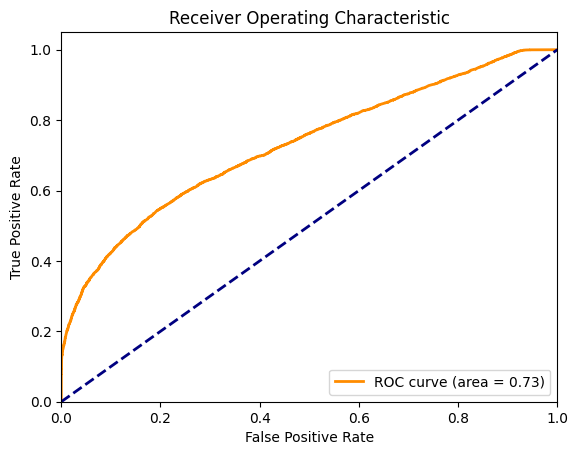

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In conclusion, the ensemble booth methods prove to be extremely efficient and useful, even with extremely complex datasets. Time to learn about Unsupervised Learning models!